
# Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

import os
import sys
from IPython.display import Audio
import itertools

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from PIL import Image

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Dataset: RAVDESS

## File loading

In [ ]:
dataset_dir = "/content/drive/MyDrive/archive" # change to your local path when excecuting
dataset_dir_list = os.listdir(dataset_dir)

emotion = []
file_path = []
for dir in dataset_dir_list:
    folder = os.listdir(dataset_dir + "/"+ dir)
    for file in folder:
        file_index = file.split('.')[0].split('-')
        emotion.append(int(file_index[2]))
        file_path.append(dataset_dir + '/' + dir + '/' + file)
        
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

SER_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
SER_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
print(SER_df)

      Emotions                                               Path
0        happy  /content/drive/MyDrive/archive/Actor_23/03-01-...
1      neutral  /content/drive/MyDrive/archive/Actor_23/03-01-...
2      disgust  /content/drive/MyDrive/archive/Actor_23/03-01-...
3          sad  /content/drive/MyDrive/archive/Actor_23/03-01-...
4        happy  /content/drive/MyDrive/archive/Actor_23/03-01-...
...        ...                                                ...
1435      fear  /content/drive/MyDrive/archive/Actor_04/03-01-...
1436     angry  /content/drive/MyDrive/archive/Actor_04/03-01-...
1437      fear  /content/drive/MyDrive/archive/Actor_04/03-01-...
1438   disgust  /content/drive/MyDrive/archive/Actor_04/03-01-...
1439  surprise  /content/drive/MyDrive/archive/Actor_04/03-01-...

[1440 rows x 2 columns]


## Dataset Statistics

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


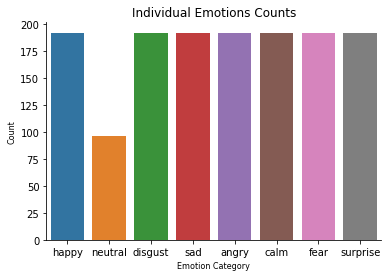

In [ ]:
plt.title('Individual Emotions Counts', size=12)
sns.countplot(SER_df.Emotions)
plt.ylabel('Count', size=8)
plt.xlabel('Emotion Category', size=8)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

## Emotion Spectrogram Example

In [ ]:
def create_waveshow(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

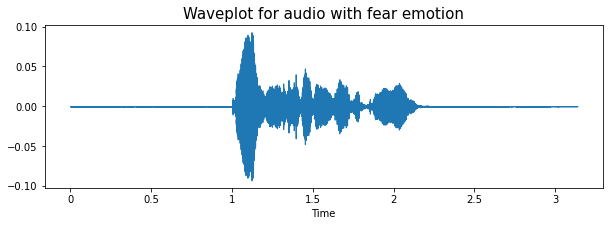

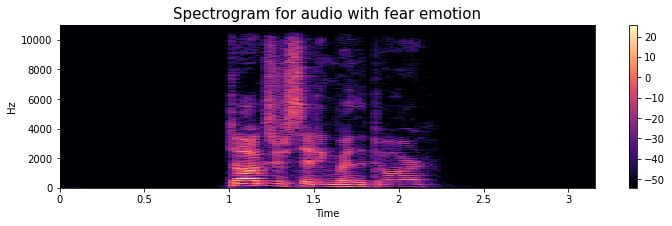

In [ ]:
emotion='fear'
path = np.array(SER_df.Path[SER_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveshow(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## All Emotion Types Example

Following is the merging of spectrograms of different emotions. 

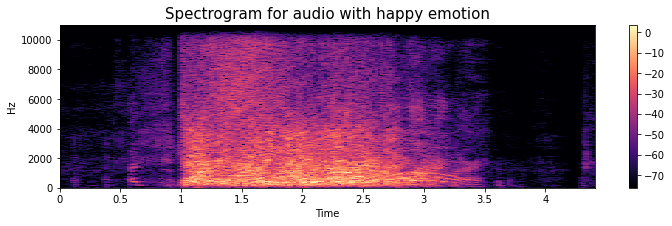

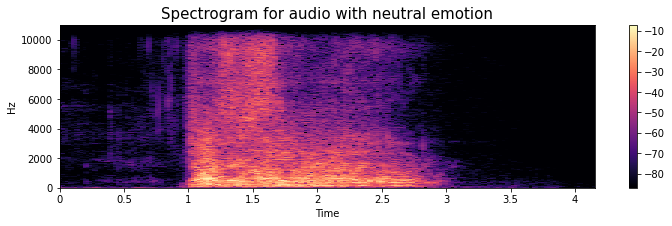

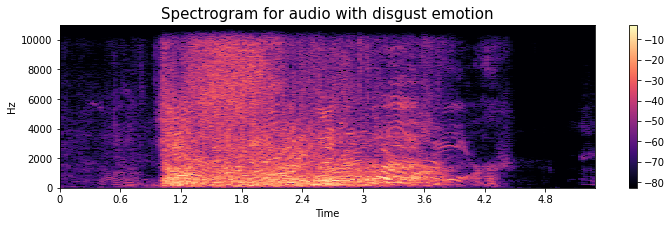

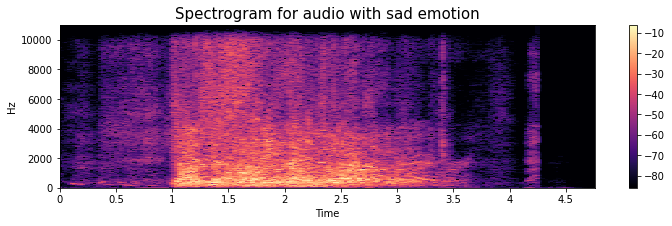

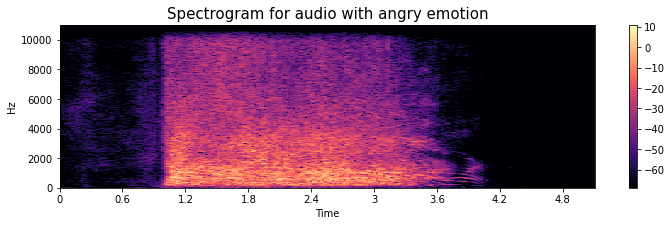

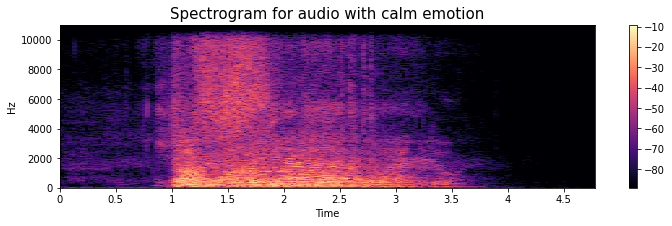

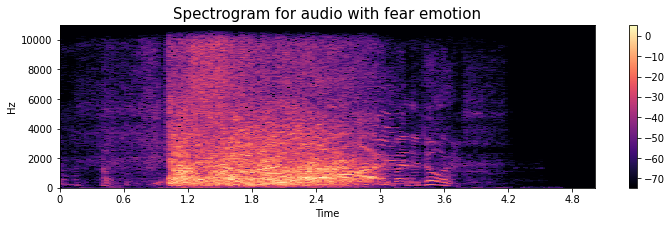

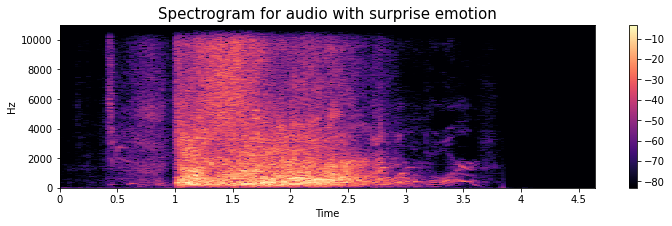

In [ ]:
for emotion in SER_df.Emotions.unique():
    path = np.array(SER_df.Path[SER_df.Emotions==emotion])
    data_sum = []
    sr_avg = 22050
    for fpath in path:
        data, sampling_rate = librosa.load(fpath)
        data_sum.append(data)
    data_array = np.array(list(itertools.zip_longest(*data_sum, fillvalue=0))).T
    data_avg = np.mean(data_array, axis=0)
    create_spectrogram(data_avg, sr_avg, emotion)

# Data Processing: Audio to MFCC Spectrogram

In [ ]:
def normalization(y,n_len):
    nframes=len(y)
    y = np.reshape(y,[nframes,1]).T
    if(nframes<n_len):
        res=n_len-nframes
        res_data=np.zeros([1,res],dtype=np.float32)
        y = np.reshape(y,[nframes,1]).T
        y=np.c_[y,res_data]
    else:
        y=y[:,0:n_len]
    return y[0]

Create the MFCC images

In [ ]:
emo_list = emotion_df.values.tolist()
for i in np.unique(emo_list):
    figure_save_path = "ravd/"+ i # The path to access to each dataset files, you can change it to your own path :)
    if not os.path.exists(figure_save_path):
        os.makedirs(figure_save_path) 

### !!!Attention!!!
This may takes you more than 30 minutes to generate the whole spectrogram dataset!!!

In [ ]:
emotion_counter= [0]*8 
emotion_list =['neutral','calm','happy','sad','angry','fear','disgust','surprise']
for i in range(len(file_path)):
    path = file_path[i]
    data, sr = librosa.load(path)
    data = normalization(data, 72000)
    mfcc = librosa.feature.mfcc(y = data, sr = sr, n_mfcc = 22)
    emotion = emo_list[i]
    #mfccs[emotion[0]].append(mfcc)
    emotion_counter_index = emotion_list.index(emotion[0])
    emotion_counter[emotion_counter_index] += 1
    file_name = emo_list[i][0]+'_'+str(emotion_counter[emotion_counter_index])
    save_path = "ravd/" + emo_list[i][0] +'/'+file_name
    np.save(save_path ,mfcc)
    img = librosa.display.specshow(mfcc, x_axis='time')
    plt.savefig(save_path+'.png')#os.path.join(save_path , file_name)
    #mfcc_img = librosa.display.specshow(mfcc, x_axis = 'time')

# Data Preparation: Make Input Dataset for Training

Use the dataset generated in last step :)

In case you don't want to generate it yourself, the generated dataset are avaliable on our github :)

In [5]:
path = r"/content/drive/MyDrive/RAVDESS_P" #  <- here to change
files = os.listdir(path)
file_name = []
labels = []

for file in files:
    file_name.append(file)
    file_label = file.split('_')
    labels.append(file_label[0])

tolabel = pd.DataFrame(labels, columns=['Emotions'])
tolabel.Emotions.replace({'neutral':0, 'calm':1, 'happy':2, 'sad':3, 'angry':4, 'fear':5, 'disgust':6, 'surprise':7}, inplace=True)
label = tolabel.Emotions.values.tolist()
#print(file_name)
#print(label)

label_dict = dict(zip(file_name,label))
print(label_dict)

{'sad_57.png': 3, 'sad_58.png': 3, 'sad_59.png': 3, 'sad_60.png': 3, 'sad_61.png': 3, 'sad_62.png': 3, 'sad_63.png': 3, 'sad_64.png': 3, 'angry_57.png': 4, 'angry_58.png': 4, 'angry_59.png': 4, 'angry_60.png': 4, 'angry_61.png': 4, 'angry_62.png': 4, 'angry_63.png': 4, 'angry_64.png': 4, 'fear_57.png': 5, 'fear_58.png': 5, 'fear_59.png': 5, 'fear_60.png': 5, 'fear_61.png': 5, 'fear_62.png': 5, 'fear_63.png': 5, 'fear_64.png': 5, 'disgust_57.png': 6, 'disgust_58.png': 6, 'disgust_59.png': 6, 'disgust_60.png': 6, 'disgust_61.png': 6, 'disgust_62.png': 6, 'disgust_63.png': 6, 'disgust_64.png': 6, 'surprise_57.png': 7, 'surprise_58.png': 7, 'surprise_59.png': 7, 'surprise_60.png': 7, 'surprise_61.png': 7, 'surprise_62.png': 7, 'surprise_63.png': 7, 'surprise_64.png': 7, 'neutral_33.png': 0, 'neutral_34.png': 0, 'neutral_35.png': 0, 'neutral_36.png': 0, 'calm_65.png': 1, 'calm_66.png': 1, 'calm_67.png': 1, 'calm_68.png': 1, 'calm_69.png': 1, 'calm_70.png': 1, 'calm_71.png': 1, 'calm_72.png'

Split the dataset

In [6]:
x_train_filename, x_test_filename, y_train_file, y_test_file = train_test_split(file_name, label, test_size = 0.2)

Examples of how we cut the image

In [7]:
img = Image.open("/content/drive/MyDrive/RAVDESS_P/angry_1.png")
img = img.convert("RGB")
img.show()

valid_area = img.crop((120, 40, 360, 250))
valid_area.show()

Generate the input arrays of CNN

In [8]:
def one_hot(array):
    One_hot_array = np.zeros((array.shape[0], len(np.unique(array)))) #generate an array completely in 0
    One_hot_array[np.arange(array.shape[0]), array] = 1 # turn the corresponding letter into 1
    return One_hot_array # return the one hot array

In [9]:
def get_the_X(file_name_list):
    arr = []
    for image in file_name_list:
        img = Image.open("/content/drive/MyDrive/RAVDESS_P/"+image) 
        img = img.convert("RGB") # apologize first! The .PNG file is RGBA image, which has 4 channels. The "A" channel will distract training, so please change to .jpg.
        valid_area = img.crop((120, 40, 360, 250))
        img = np.array(valid_area)
        arr.append(img)
    X = np.array(arr)
    return X
#may take 30 seconds :)
x_train = get_the_X(x_train_filename)
x_test = get_the_X(x_test_filename)
print(x_train.shape)
print(x_test.shape)
y_train = np.asarray(y_train_file)
y_train = one_hot(y_train)
y_test = np.asarray(y_test_file)
y_test = one_hot(y_test)
print(type(y_train),y_train.shape) 

(1152, 210, 240, 3)
(288, 210, 240, 3)
<class 'numpy.ndarray'> (1152, 8)


# Model: CNN for classification

In [10]:
import keras
from keras.utils import plot_model
from keras import regularizers

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32,1,activation = 'relu', input_shape = (210,240,3))) 
model.add(keras.layers.Conv2D(16,3,padding = 'same', activation = 'relu', kernel_regularizer= regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPooling2D(pool_size=(5))) 
model.add(keras.layers.Conv2D(16,3,activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(16,3,activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(16,3,activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPooling2D(pool_size=(3)))
model.add(keras.layers.Conv2D(32,3,activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8,activation = 'softmax'))

plot_model(model, to_file='mfcc.png',show_shapes = True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 210, 240, 32)      128       
                                                                 
 conv2d_1 (Conv2D)           (None, 210, 240, 16)      4624      
                                                                 
 dropout (Dropout)           (None, 210, 240, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 48, 16)        2320      
                                                                 
 dropout_1 (Dropout)         (None, 42, 48, 16)        0         
                                                        

# Training and Testing

In [11]:
opt = keras.optimizers.Adam(learning_rate = 0.001, decay = 1e-6)#RMSprop 
model.compile(loss='categorical_crossentropy',optimizer = opt, metrics=['accuracy'])
import keras
history = model.fit(x_train,y_train,batch_size = 16, epochs = 50, verbose=1,
          validation_data=(x_test, y_test))#, callbacks = callbacks_list

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
72/72 [==============================] - 12s 34ms/step - loss: 8.2847 - accuracy: 0.1198 - val_loss: 2.1408 - val_accuracy: 0.1285
Epoch 2/50
72/72 [==============================] - 2s 31ms/step - loss: 2.1352 - accuracy: 0.1554 - val_loss: 2.1245 - val_accuracy: 0.1354
Epoch 3/50
72/72 [==============================] - 2s 31ms/step - loss: 2.0921 - accuracy: 0.1832 - val_loss: 2.0351 - val_accuracy: 0.2535
Epoch 4/50
72/72 [==============================] - 2s 31ms/step - loss: 1.9284 - accuracy: 0.2734 - val_loss: 1.8187 - val_accuracy: 0.3333
Epoch 5/50
72/72 [==============================] - 2s 31ms/step - loss: 1.8395 - accuracy: 0.3021 - val_loss: 1.8887 - val_accuracy: 0.3160
Epoch 6/50
72/72 [==============================] - 2s 34ms/step - loss: 1.8248 - accuracy: 0.3177 - val_loss: 1.8707 - val_accuracy: 0.3229
Epoch 7/50
72/72 [==============================] - 3s 39ms/step - loss: 1.7120 - accuracy: 0.3637 - val_loss: 1.6966 - val_accuracy: 0.4375
Epoch 8/50
7

[1 5 6 ... 4 3 1] (1152,)


Text(0, 0.5, 'Principal Component 2')

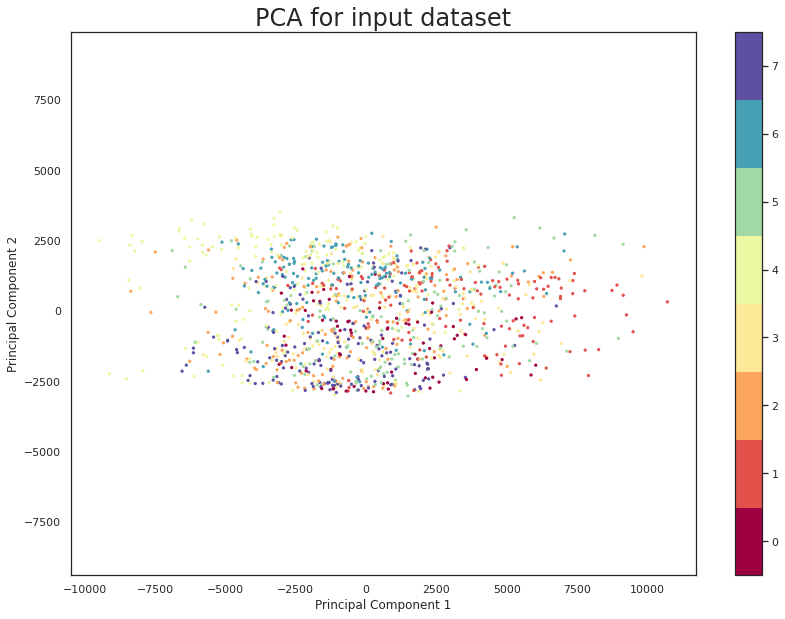

In [ ]:
# PCA test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

#For standardising the data
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

y = y_train
#condition = y_train==1
#y = np.extract(condition, y_train)
y = np.argmax(y, axis=1)
# convert the labels to a one-dimensional array
y = np.squeeze(y)
print(y, y.shape)
x = x_train.reshape(1152,151200)


standardized_data = StandardScaler().fit_transform(x)
#print(standardized_data.shape)

#pca
pca = PCA(n_components=2) # project from 256 to 2 dimensions
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principal_df.shape

plt.scatter(principalComponents[:, 0], principalComponents[:, 1], s= 5, c=y, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
plt.title('PCA for input dataset', fontsize=24);
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE map of input emotions')

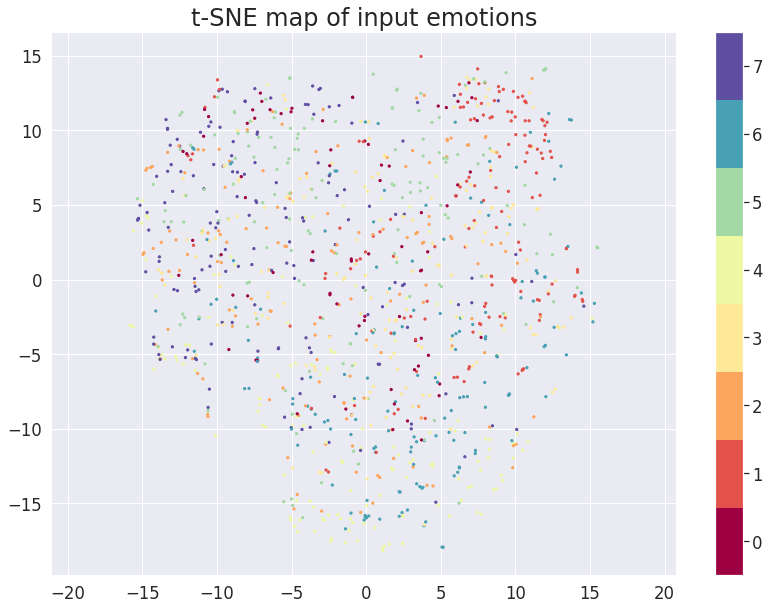

In [ ]:
#t_sne
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(x)
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(x)

plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=y, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
plt.title('t-SNE map of input emotions', fontsize=24)

# Result Analysis

Confusion matrix

In [12]:
predicted = model.predict(x_test)
classes_x=np.argmax(predicted,axis=1)
test_predict = pd.DataFrame(classes_x)
#print(test_predict)
matrix = confusion_matrix(test_predict, y_test_file)

9/9 [==============================] - 0s 27ms/step


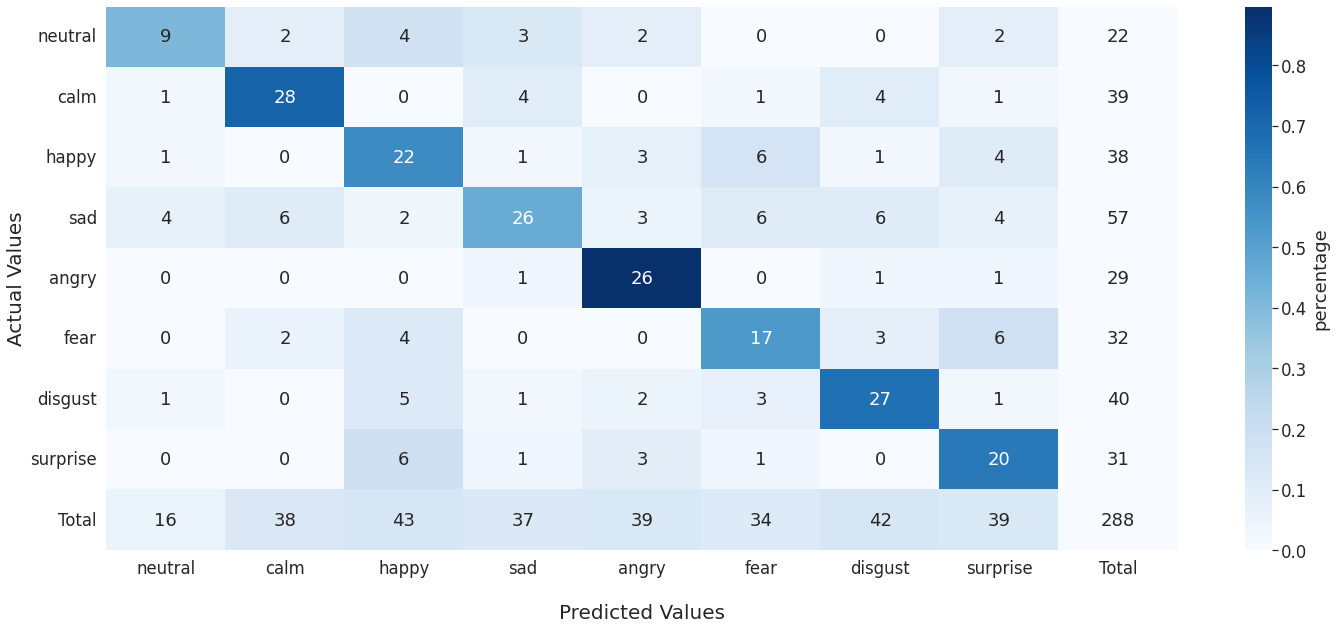

In [13]:
label = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
df = pd.DataFrame(matrix, index = label, columns = label)
df['Total']= df.sum(axis = 1)
df.loc['Total']=df.sum()

df_p = df.div(df.Total, axis = 0)
df_p.Total = 0

plt.figure(figsize=(24,10))
sns.set(font_scale = 1.5)

ax = sns.heatmap(data = df_p, annot = df, cmap = 'Blues', fmt = "d", cbar_kws = {'label':'percentage'})

ax.set_xlabel('\nPredicted Values',size = 20)
ax.set_ylabel('Actual Values', size = 20)

plt.show()

# Predition

To be continue:
steps for make a new prediction from collected new raw data:

1.   get audio wave
2.   raw audip processing
3.   do the MFCC to get the image
4.   slice the data to the size that can be predict
5.   input into the model and get a prediction


# An easy-to-use interface.

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.8 MB 4.8 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 2.3 MB 51.3 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 56 kB 6.6 MB/s 
     |████████████████████████████████| 106 kB 79.8 MB/s 
     |████████████████████████████████| 278 kB 79.3 MB/s 
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 80 kB 11.9 MB/s 
     |████████████████████████████████| 69 kB 9.5 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4711 sha256=137b085c5ff25473c42ab3864cb9ab7e4498bcde4c82469578dbb8e1b8f2ad72
  Stored in direc

In [ ]:
import gradio as gr
def api(input):
  data, sr = librosa.load(input)
  data = normalization(data, 72000)
  mfcc = librosa.feature.mfcc(y = data, sr = sr, n_mfcc = 22)

  #mfccs[emotion[0]].append(mfcc)

  img = librosa.display.specshow(mfcc, x_axis='time')

  #mfcc_img = librosa.display.specshow(mfcc, x_axis = 'time')
  return img, mfcc
demo = gr.Interface(fn=api, inputs="audio", outputs="image")
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>